In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Classical Approach

Often called a "search algorithm", but is actually at its core a "satisfiability" or "function inversse" algorithm.

Imagine a discrete function $f$ on a sample space of size $N$ such that:
$$[1,2,3,4,5,6,...,N] -f> [f(1),f(2),f(3),...,f(N)]$$

For some $y_{target}$ and no sense of shape of this arbitrary function, The algorithm determines the value $x$ such that $f(x) = y_{target}$

Classically, this involves searching through the sample space and applying a function until the match is found.

We define the function that determines the satisfiability of a given value, generically, as an "oracle":

In [2]:
y_target = 3

def f(x):
    return x # can be any function!

def oracle(x):
    return f(x) == y_target # logic to determine this oracle can be anything ! This is just the simplest example ... but hopefully only ONE satisfying value or answers are inconsistent

N = 10

for i in range(N):
    if oracle(i):
        print("%i satisfies f(x)" % i)


3 satisfies f(x)


As shown by the loop, the discrete, naive classical search algorithm can search a space in time complexity linear to the space:

$$O(N)$$

## The Quantum Version !!

The quantum version of this algorithm is theoretically quadratically faster than the classical algorithm... Let's see how it works!

Our quantum strategy is as follows:
1) Model the qubits as discrete values to put into our oracle
2) To separate the satisfying value from the rest, we can negate the qubit from the starting value, so that the target value is the only one negative at the end.
3) We can then use amplitude amplification, on top of a reflection operator, to filter this negative value from the rest and return it with highest probability.



## 1,2) Our quantum oracle!!

Our oracle, f(x), with a defined target ($x=\omega$) can have defined sign flipping with this simple unitary matrix:

$$U_\omega |x> = (-1)^{f(x)} |x>$$

**Defining a simple example:** let's say f(x) = x and $\omega=3$. In this case, the sample can be modeled with 2 qubits, and $|11>$ will be sent to $-|11>$. This is described by the CZ gate!

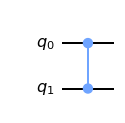

In [7]:
oracle = QuantumCircuit(2,name='oracle')
oracle.cz(0,1)
oracle.to_gate()
oracle.draw()

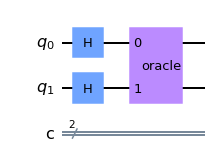

In [9]:
grover = QuantumCircuit(2,2)
grover.h([0,1])
grover.append(oracle,[0,1])
grover.draw()

In [12]:
backend = Aer.get_backend('statevector_simulator')
job = execute(grover,backend)
result = job.result()
sv = result.get_statevector()
np.around(sv,2)

array([ 0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j])

## 3) Reflection operator

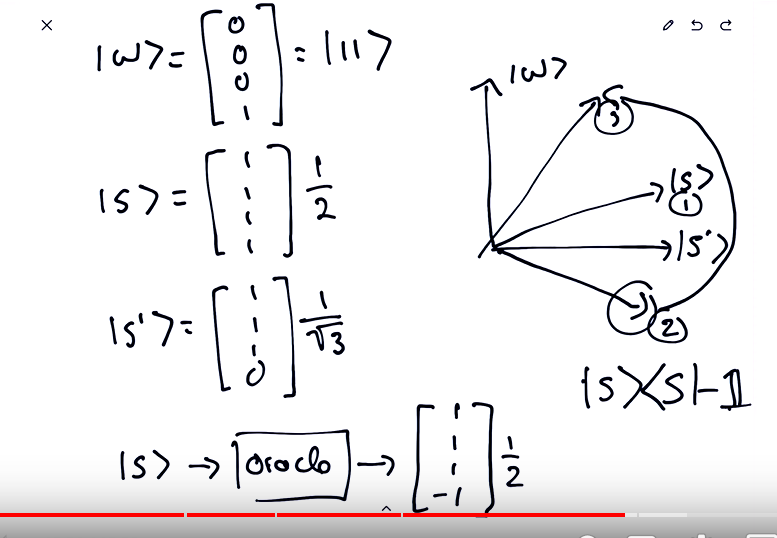
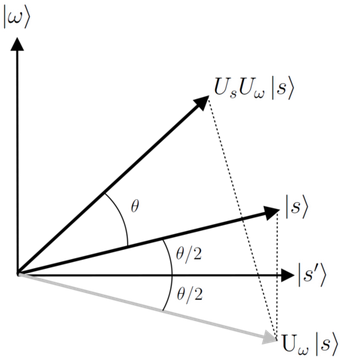

Reflecting the oracle output qubits across the initial state results in a value that collapses a limiting value closer to the target $\omega$... Repeat this $\sqrt(N)$ times to assure collapse on the target!

This is called **Grover's Diffusion:**

$$U_s = 2|s><s| - I$$

Achievable in our case by doing a Z then CZ gate between two Hadamards:


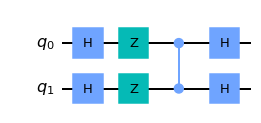

In [14]:
reflection = QuantumCircuit(2,name='reflection')
reflection.h([0,1])
reflection.z([0,1])
reflection.cz(0,1)
reflection.h([0,1])
reflection.to_gate()
reflection.draw()

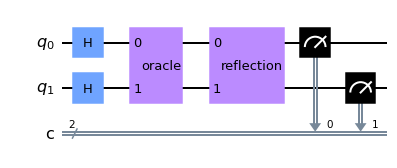

In [16]:
backend = Aer.get_backend('qasm_simulator')
grover = QuantumCircuit(2,2)
grover.h([0,1])
grover.append(oracle,[0,1])
grover.append(reflection,[0,1]) # repeat sqrt(N) times...
grover.measure([0,1],[0,1])
grover.draw()

In [17]:
job = execute(grover,backend,shots=1)
job.result().get_counts()

{'11': 1}